# STAT41130 — RNNs & LSTMs (Fixed): Using a Real Time Series via Siphon/NCSS

This version fixes the single-observation issue in Example 2 by retrieving a true time series from the **GFS (0.5°) Best** dataset using Siphon’s **NCSS**. Examples 4 and 6 also use this source.

In [ ]:
# If needed, install dependencies (uncomment in a fresh environment)
# %pip install torch --quiet
# %pip install metpy siphon xarray netCDF4 numpy pandas matplotlib scikit-learn --quiet

In [1]:
import numpy as np
import pandas as pd
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta, timezone
import warnings

warnings.filterwarnings("ignore")
torch.manual_seed(0); np.random.seed(0)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cpu'

In [2]:
def make_sequences(array_like, seq_len, target_horizon=1, target_cols=None):
    data = np.asarray(array_like)
    T, F = data.shape
    if target_cols is None: target_cols = [0]
    X, y = [], []
    for t in range(T - seq_len - target_horizon + 1):
        X.append(data[t:t+seq_len, :])
        y.append(data[t+seq_len+target_horizon-1, target_cols])
    return np.array(X, np.float32), np.array(y, np.float32)

class SeqDataset(Dataset):
    def __init__(self, X, y): self.X=torch.tensor(X); self.y=torch.tensor(y)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i): return self.X[i].float(), self.y[i].float()

def train_epoch(model, loader, criterion, optimizer):
    model.train(); total=0.0
    for Xb, yb in loader:
        Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad(); out = model(Xb)
        loss = criterion(out, yb); loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step(); total += loss.item()*Xb.size(0)
    return total/len(loader.dataset)

@torch.no_grad()
def eval_epoch(model, loader, criterion):
    model.eval(); total=0.0
    for Xb, yb in loader:
        Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
        out = model(Xb); loss = criterion(out, yb)
        total += loss.item()*Xb.size(0)
    return total/len(loader.dataset)

@torch.no_grad()
def predict(model, X):
    X = torch.tensor(X, dtype=torch.float32, device=DEVICE)
    return model.eval()(X).cpu().numpy()

def plot_series(true_series, pred_series=None, title=""):
    plt.figure(figsize=(8,3)); plt.plot(true_series, label="true")
    if pred_series is not None: plt.plot(pred_series, label="pred")
    plt.title(title); plt.legend(); plt.show()

## 1) Toy RNN on synthetic data

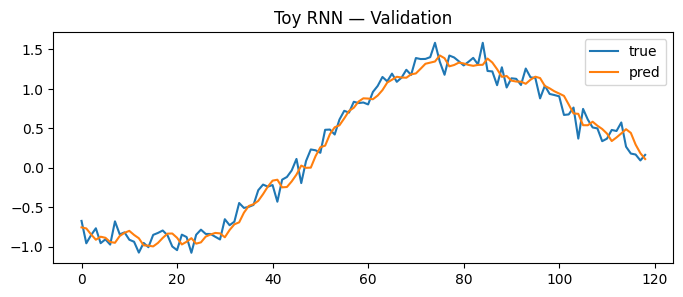

In [3]:
T = 500; t = np.arange(T)
series = np.sin(0.03*t) + 0.5*np.sin(0.07*t+1.2) + 0.1*np.random.randn(T)
data = series.reshape(-1,1); seq_len=24
X, y = make_sequences(data, seq_len, 1, [0])
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.25, shuffle=False)

train_ds = SeqDataset(X_tr, y_tr); val_ds = SeqDataset(X_val, y_val)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=64)

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden, out):
        super().__init__(); self.rnn=nn.RNN(input_size, hidden, batch_first=True); self.fc=nn.Linear(hidden,out)
    def forward(self,x): out,_=self.rnn(x); return self.fc(out[:,-1,:])

rnn_toy = SimpleRNN(1,32,1).to(DEVICE); crit=nn.MSELoss(); opt=torch.optim.Adam(rnn_toy.parameters(),1e-2)
for _ in range(25):
    train_epoch(rnn_toy, train_loader, crit, opt); _=eval_epoch(rnn_toy, val_loader, crit)
y_pred_toy = predict(rnn_toy, X_val); plot_series(y_val.squeeze(), y_pred_toy.squeeze(), "Toy RNN — Validation")

## 2) Real-world RNN — GFS (0.5°) time series via Siphon/NCSS

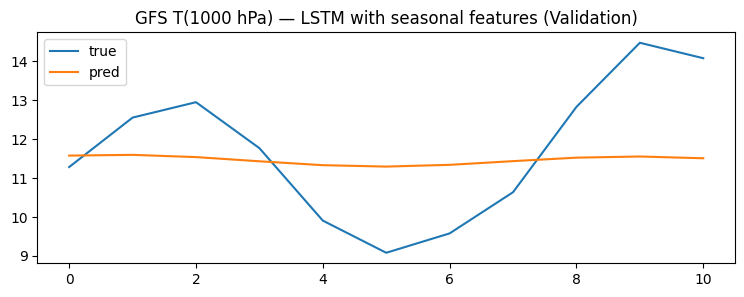

In [4]:
from siphon.catalog import TDSCatalog
from netCDF4 import num2date
import pandas as pd
import numpy as np
import torch, torch.nn as nn
from datetime import datetime, timedelta, timezone
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader

# --- 1) Fetch a TRUE time series from GFS "Best" for the PAST 7 days ---
def fetch_gfs_timeseries(lat, lon, var='Temperature_isobaric', level_pa=100000, days=7):
    cat = TDSCatalog(
        'http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p5deg/'
        'catalog.xml?dataset=grib/NCEP/GFS/Global_0p5deg/Best'
    )
    ds = (list(cat.datasets.values())[0] if isinstance(cat.datasets, dict) else cat.datasets[0])
    ncss = ds.subset()

    now = datetime.now(timezone.utc)
    start = now - timedelta(days=days)
    end   = now

    q = ncss.query()
    q.lonlat_point(lon, lat).vertical_level(level_pa).time_range(start, end)
    q.variables(var).accept('netcdf')
    resp = ncss.get_data(q)

    arr = resp.variables[var][:].squeeze()
    tvar = resp.variables['time']
    times = num2date(tvar[:].squeeze(), tvar.units, only_use_cftime_datetimes=False)
    return np.array(times), np.array(arr, np.float32)

# Location: Dublin, IE
lat, lon = 53.35, -6.26

times_raw, temp_pa = fetch_gfs_timeseries(lat, lon, 'Temperature_isobaric', level_pa=100000, days=7)

# --- 2) Put into a DataFrame, convert to Celsius, resample to 3-hour cadence ---
ts = pd.DataFrame(
    {'T_K': temp_pa},
    index=pd.to_datetime(times_raw)
).sort_index()

ts = ts[~ts.index.duplicated(keep='first')]
ts = ts.resample('3H').interpolate(limit_direction='both')  # regular cadence
ts['T_C'] = ts['T_K'] - 273.15

# --- 3) Add seasonal/cyclical time features (diurnal + annual/seasonal) ---
hr = ts.index.hour.values
doy = ts.index.dayofyear.values
ts['sin_hr'] = np.sin(2*np.pi * hr / 24.0)
ts['cos_hr'] = np.cos(2*np.pi * hr / 24.0)
ts['sin_doy'] = np.sin(2*np.pi * doy / 365.25)
ts['cos_doy'] = np.cos(2*np.pi * doy / 365.25)

# Feature matrix (F): temperature history + calendar signals; Target: next-step T_C
features = ts[['T_C','sin_hr','cos_hr','sin_doy','cos_doy']].astype('float32').values
target   = ts[['T_C']].astype('float32').values  # for convenience; we’ll shift via make_sequences

def make_sequences(array_like, seq_len, target_horizon=1, target_cols=None):
    data = np.asarray(array_like, dtype=np.float32)
    T, F = data.shape
    if target_cols is None: target_cols = [0]
    X, y = [], []
    for t in range(T - seq_len - target_horizon + 1):
        X.append(data[t:t+seq_len, :])
        y.append(data[t+seq_len+target_horizon-1, target_cols])
    return np.array(X, np.float32), np.array(y, np.float32)

# --- 4) Build windows (longer lookback helps capture diurnal cycle) ---
seq_len = 16  # 16*3h ≈ 2 days lookback
X_all, y_all = make_sequences(features, seq_len=seq_len, target_horizon=1, target_cols=[0])

# Train/val split by time (no shuffle)
X_tr, X_val, y_tr, y_val = train_test_split(X_all, y_all, test_size=0.25, shuffle=False)

# --- 5) Scale inputs AND target using only the train split ---
Xsc = StandardScaler().fit(X_tr.reshape(-1, X_tr.shape[-1]))
ysc = StandardScaler().fit(y_tr)  # scale target improves MSE opt

def apply_sc(scaler, X):
    shp = X.shape
    return scaler.transform(X.reshape(-1, shp[-1])).reshape(shp)

X_tr_sc = apply_sc(Xsc, X_tr)
X_val_sc = apply_sc(Xsc, X_val)
y_tr_sc  = ysc.transform(y_tr)
y_val_sc  = ysc.transform(y_val)

class SeqDataset(Dataset):
    def __init__(self, X, y): self.X = torch.tensor(X); self.y = torch.tensor(y)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i): return self.X[i].float(), self.y[i].float()

train_w = DataLoader(SeqDataset(X_tr_sc, y_tr_sc), batch_size=128, shuffle=True)
val_w   = DataLoader(SeqDataset(X_val_sc, y_val_sc), batch_size=128, shuffle=False)

# --- 6) Model: small LSTM + early stopping ---
class LSTMForecaster(nn.Module):
    def __init__(self, in_feats, hidden=64, out_feats=1):
        super().__init__()
        self.lstm = nn.LSTM(in_feats, hidden, batch_first=True)
        self.fc   = nn.Linear(hidden, out_feats)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = LSTMForecaster(in_feats=X_tr_sc.shape[-1], hidden=64, out_feats=1).to(DEVICE)
crit   = nn.MSELoss()
opt    = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

def train_epoch(model, loader, criterion, optimizer):
    model.train(); total=0.0
    for Xb, yb in loader:
        Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        loss = criterion(model(Xb), yb)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total += loss.item() * Xb.size(0)
    return total/len(loader.dataset)

@torch.no_grad()
def eval_epoch(model, loader, criterion):
    model.eval(); total=0.0
    for Xb, yb in loader:
        Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
        loss = criterion(model(Xb), yb)
        total += loss.item() * Xb.size(0)
    return total/len(loader.dataset)

best_val = float('inf'); patience=6; bad=0
for ep in range(50):  # a few more epochs but stop early if no progress
    tr = train_epoch(model, train_w, crit, opt)
    va = eval_epoch(model, val_w,   crit)
    if va + 1e-6 < best_val:
        best_val = va; bad = 0; best_state = {k:v.detach().cpu().clone() for k,v in model.state_dict().items()}
    else:
        bad += 1
    if bad >= patience: break

# restore best
model.load_state_dict(best_state)

@torch.no_grad()
def predict(model, X):
    X = torch.tensor(X, dtype=torch.float32, device=DEVICE)
    yhat_sc = model.eval()(X).cpu().numpy()
    return ysc.inverse_transform(yhat_sc)  # invert target scaling

y_hat_val = predict(model, X_val_sc).squeeze()
y_true_val = y_val.squeeze()              # already unscaled (we never scaled this copy)
# Compare on the original Celsius scale
import matplotlib.pyplot as plt
plt.figure(figsize=(9,3))
plt.plot(y_true_val, label='true')
plt.plot(y_hat_val,  label='pred')
plt.title('GFS T(1000 hPa) — LSTM with seasonal features (Validation)')
plt.legend(); plt.show()


## 3) Toy LSTM

In [ ]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden, out):
        super().__init__(); self.lstm=nn.LSTM(input_size, hidden, batch_first=True); self.fc=nn.Linear(hidden,out)
    def forward(self,x): out,_=self.lstm(x); return self.fc(out[:,-1,:])

lstm_toy = SimpleLSTM(1,32,1).to(DEVICE); opt_l=torch.optim.Adam(lstm_toy.parameters(),1e-2); crit=nn.MSELoss()
for _ in range(25):
    train_epoch(lstm_toy, train_loader, crit, opt_l); _=eval_epoch(lstm_toy, val_loader, crit)
y_pred_tl = predict(lstm_toy, X_val); plot_series(y_val.squeeze(), y_pred_tl.squeeze(), "Toy LSTM — Validation")

## 4) Real-world LSTM — same GFS time series

In [ ]:
lstm_w = SimpleLSTM(1,32,1).to(DEVICE); opt_wl=torch.optim.Adam(lstm_w.parameters(),5e-3); crit_w=nn.MSELoss()
for _ in range(20):
    train_epoch(lstm_w, train_w, crit_w, opt_wl); _=eval_epoch(lstm_w, val_w, crit_w)
y_pred_wl = predict(lstm_w, Xw_val_sc); plot_series(yw_val.squeeze(), y_pred_wl.squeeze(), "LSTM on GFS Temperature — Validation")

## 5) RNN vs LSTM — comparison

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,3))
plt.plot(yw_val.squeeze(), label="true"); plt.plot(y_pred_w.squeeze(), label="RNN pred"); plt.plot(y_pred_wl.squeeze(), label="LSTM pred")
plt.title("GFS Temperature — RNN vs LSTM on Validation"); plt.legend(); plt.show()

## 6) Multi-output LSTM — two pressure levels (1000 & 850 hPa)

In [ ]:
_, t1000 = fetch_gfs_timeseries(lat, lon, 'Temperature_isobaric', 100000, 7)
_, t850  = fetch_gfs_timeseries(lat, lon, 'Temperature_isobaric',  85000, 7)
Tmin = min(len(t1000), len(t850))
multi = np.stack([t1000[:Tmin], t850[:Tmin]], axis=1)
Xm, ym = make_sequences(multi, seq_len=12, target_horizon=1, target_cols=[0,1])

Xm_tr, Xm_val, ym_tr, ym_val = train_test_split(Xm, ym, test_size=0.25, shuffle=False)
scaler_m = StandardScaler().fit(Xm_tr.reshape(-1, Xm_tr.shape[-1]))
Xm_tr_sc = scaler_m.transform(Xm_tr.reshape(-1, Xm_tr.shape[-1])).reshape(Xm_tr.shape)
Xm_val_sc = scaler_m.transform(Xm_val.reshape(-1, Xm_val.shape[-1])).reshape(Xm_val.shape)

train_m = DataLoader(SeqDataset(Xm_tr_sc, ym_tr), batch_size=64, shuffle=True)
val_m   = DataLoader(SeqDataset(Xm_val_sc, ym_val), batch_size=64)

lstm_m = SimpleLSTM(Xm_tr_sc.shape[2], 48, 2).to(DEVICE); opt_m = torch.optim.Adam(lstm_m.parameters(), 5e-3); crit_m = nn.MSELoss()
for _ in range(25):
    train_epoch(lstm_m, train_m, crit_m, opt_m); _=eval_epoch(lstm_m, val_m, crit_m)

y_pred_m = predict(lstm_m, Xm_val_sc)
import matplotlib.pyplot as plt
plt.figure(figsize=(8,3)); plt.plot(ym_val[:,0], label="true T(1000 hPa)"); plt.plot(y_pred_m[:,0], label="pred T(1000 hPa)"); plt.legend(); plt.show()
plt.figure(figsize=(8,3)); plt.plot(ym_val[:,1], label="true T(850 hPa)"); plt.plot(y_pred_m[:,1], label="pred T(850 hPa)"); plt.legend(); plt.show()